In [1]:
%load_ext autoreload
%autoreload 2

In [23]:
import gzip
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import sys

# import own modules
try:
    from lsh import LSH
    from utils import *
    from autoencoder import Autoencoder
except ModuleNotFoundError:
    sys.path.append("../src")
    print("path to src files: {}".format(sys.path[-1]))
    from lsh import LSH
    from utils import *
    from autoencoder import Autoencoder

In [18]:
path = "../../../../data/"
training_data = load_mnist(path)
test_data = load_mnist(path, kind="test")
y_train = training_data[1]
y_test = test_data[1]
x_train = training_data[0].reshape(len(y_train), 28, 28)
x_test = test_data[0].reshape(len(y_test), 28, 28)
del training_data, test_data

In [19]:
x_train = x_train.astype("float32")/255
x_test = x_test.astype("float32")/255

In [24]:
latent_dim = 64
autoencoder = Autoencoder(latent_dim)
autoencoder.compile(optimizer='adam', loss=losses.MeanSquaredError())
autoencoder.fit(x_train, x_train,
                epochs=10,
                shuffle=True,
                validation_data=(x_test, x_test))

Epoch 1/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.0236 - val_loss: 0.0132
Epoch 2/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.0116 - val_loss: 0.0105
Epoch 3/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.0100 - val_loss: 0.0097
Epoch 4/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.0094 - val_loss: 0.0094
Epoch 5/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.0091 - val_loss: 0.0091
Epoch 6/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.0090 - val_loss: 0.0090
Epoch 7/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.0089 - val_loss: 0.0091
Epoch 8/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.0088 - val_loss: 0.0090
Epoch 9/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.0087 - val_loss: 0.0088
Epoch 10/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.008

In [ ]:
encoded_imgs = autoencoder.encoder(x_test).numpy()
decoded_imgs = autoencoder.decoder(encoded_imgs).numpy()

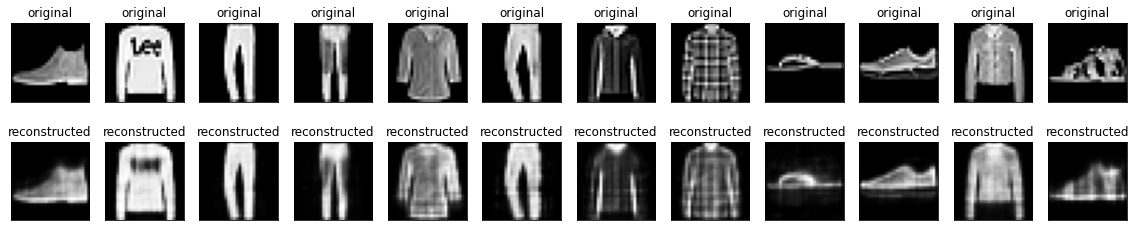

In [28]:
n = 12
plt.figure(figsize=(20, 4))
for i in range(n):
  # display original
  ax = plt.subplot(2, n, i + 1)
  plt.imshow(x_test[i])
  plt.title("original")
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)

  # display reconstruction
  ax = plt.subplot(2, n, i + 1 + n)
  plt.imshow(decoded_imgs[i])
  plt.title("reconstructed")
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)
plt.show()

In [29]:
embedding = autoencoder.encoder(x_train).numpy()

In [30]:
embedding.shape

(60000, 64)

In [93]:
lsh = LSH(embedding, rows_per_band=7, num_total_hashes=400, hash_func="euclidean", dist_metric="euclidean", bucket_width=10)
lsh.build_hashtables()

In [118]:
query = 10

In [119]:
anns = lsh.get_near_duplicates(
    autoencoder.encoder(x_test[[query]]).numpy()[0],
    num_duplicates=20
)

510 candidates have been retrieved. Calculate exact distance on those..


# DNN Retrievals

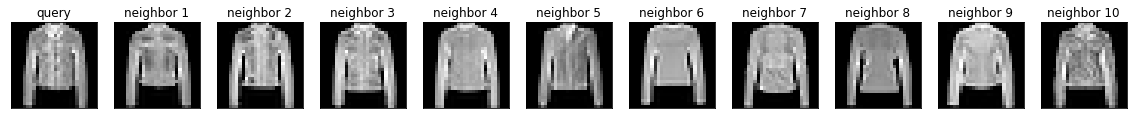

In [120]:
n = np.min((10, len(anns)))
plt.figure(figsize=(20, 4))
ax = plt.subplot(1, n+1, 1)
plt.imshow(x_test[query])
plt.title("query")
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
for i in range(n):
    ax = plt.subplot(1, n+1, i+2)
    plt.imshow(x_train[anns[i][0]])
    plt.title(f"neighbor {i+1}")
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

# Baseline

In [122]:
cat_query = y_test[query]

In [129]:
baseline_selections = np.random.choice(np.where(y_train == cat_query)[0], n)

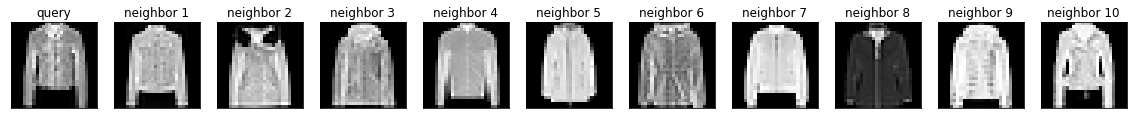

In [130]:
plt.figure(figsize=(20, 4))
ax = plt.subplot(1, n+1, 1)
plt.imshow(x_test[query])
plt.title("query")
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
for i in range(n):
    ax = plt.subplot(1, n+1, i+2)
    plt.imshow(x_train[baseline_selections[i]])
    plt.title(f"neighbor {i+1}")
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

In [133]:
res = autoencoder.predict(x_test[[0]])

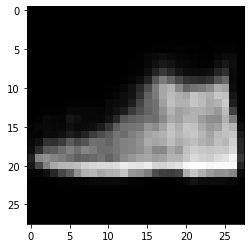

In [136]:
plt.imshow(res[0])